# Multi Classification Neural Network

Create a Neural Network to classify Control, 15q duplication, and 16p11 deletion

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data
df = pd.read_csv('Organoid Files/all_autism_fpkm_iqr_1.5_outliers_multi_class.csv', header=0, index_col=0)
df.head()

,Autism,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,TIMM9,...,NHLRC3,CCDC130,PIK3C3,PRKAB2,EIF2B3,C15orf61,IPP,ASB3,EHD4,NRSN2
PGP1-1,0,5.561823,9.167399,4.762467,4.259699,3.333153,5.245319,15.288924,10.670947,12.501312,...,3.577807,10.246243,9.379072,7.974797,6.506580,1.808342,2.624415,5.473228,9.892221,14.017985
PGP1-2,0,2.050032,6.121957,3.086031,3.888580,3.064389,4.530108,14.225061,11.109630,14.227982,...,2.951153,8.455335,13.197261,7.847511,6.687741,1.614225,3.276070,7.483068,7.377414,11.613564
PGP1-3,0,2.481599,14.205795,8.663784,2.988719,13.747564,6.189141,18.021990,15.850792,9.134396,...,3.211442,9.928194,7.313368,9.023667,6.744241,3.626686,2.221963,5.087976,2.392554,15.666102
GM23716-1,0,4.396121,15.263531,8.198981,3.433083,13.873706,5.018456,17.714552,15.832140,8.492397,...,3.052629,9.895930,7.927309,9.817574,6.570986,3.988325,2.459700,4.626596,2.301205,16.500382
GM23716-2,0,3.721746,14.125613,10.278191,3.331196,13.211928,5.620373,15.806883,15.434513,8.410669,...,2.743381,9.354041,8.525394,8.338526,5.990253,3.849378,2.494851,4.843815,2.285043,18.534124


In [3]:
#define target/features

y = df.Autism
x = df.iloc[:,1:]

x.shape

(71, 8163)

In [78]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

#create early stop
early_stop = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.01,patience=5, verbose=1)

#create model
model = keras.Sequential([
    layers.Dense(units=100, activation='relu',input_shape=[8163]),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=50, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=10, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=1,activation='sigmoid')
])

#compile model with functions
opt = Adam(learning_rate=0.000001)
model.compile(
    optimizer=opt,
    loss='Poisson',
    metrics=['accuracy']
)

In [79]:
#import cross fold validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

mm = StandardScaler()

k = 5 #number of folds

#initialize kfold
kf = KFold(n_splits=k, random_state=1, shuffle=True)

#create empty list to hold scores
acc_score = []

#split training data
for train_index,test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_scaled = mm.fit_transform(x_train)
    x_test_scaled = mm.fit_transform(x_test)
    
    #fit model with training data
    history = model.fit(x_train_scaled, y_train, validation_data=(x_test_scaled,y_test),
                        batch_size = 20, epochs=100, shuffle=True, callbacks=[early_stop])
    pred = model.predict(x_test_scaled)
    
    #record accuracy of each fold
    acc = accuracy_score(y_test,pred.round())
    acc_score.append(acc)

#Print accuracy of the model
avg_score = sum(acc_score)/k
print('Accuracy of each fold = {}'.format(acc_score))
print('Avg accuracy = {}'.format(avg_score))

Epoch 1/100
3/3 [==============================] - 1s 71ms/step - loss: 1.1265 - accuracy: 0.4268 - val_loss: 1.4025 - val_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.1957 - accuracy: 0.3652 - val_loss: 1.4007 - val_accuracy: 0.2000
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.5614 - accuracy: 0.3563 - val_loss: 1.4007 - val_accuracy: 0.2000
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 1.0695 - accuracy: 0.3384 - val_loss: 1.4017 - val_accuracy: 0.2000
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 1.5119 - accuracy: 0.3223 - val_loss: 1.4016 - val_accuracy: 0.2000
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 0.9824 - accuracy: 0.4786 - val_loss: 1.3997 - val_accuracy: 0.2000
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.3228 - accuracy: 0.4732 - val_loss: 1.4010 - val_accuracy: 0.2000
Epoch 8/100
3/3 [===

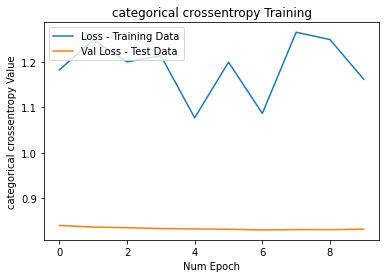

In [80]:
plt.plot(history.history['loss'], label='Loss - Training Data')
plt.plot(history.history['val_loss'], label='Val Loss - Test Data')
plt.title('categorical crossentropy Training')
plt.ylabel('categorical crossentropy Value')
plt.xlabel('Num Epoch')
plt.legend(loc='upper left')
plt.show()

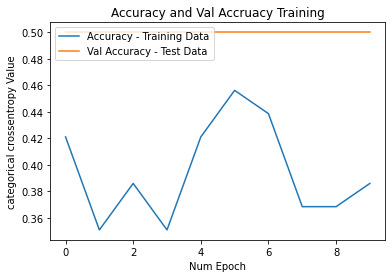

In [81]:
plt.plot(history.history['accuracy'], label='Accuracy - Training Data')
plt.plot(history.history['val_accuracy'], label='Val Accuracy - Test Data')
plt.title('Accuracy and Val Accruacy Training')
plt.ylabel('categorical crossentropy Value')
plt.xlabel('Num Epoch')
plt.legend(loc='upper left')
plt.show()